# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install protobuf==3.20.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 5.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyinstrument-cext: filename=pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl size=6299 sha256=d2ab6edde9b6082b2a353bd109290d2fbaa3127e7240b772377da50852e810e7
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0f/8b/7a/5f7fd1dd6d3cbb3d350d4c832c5e2f962687749f6d67d573a6
Successfully built pyinstrument-cext
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:0000:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4


In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import boto3
import os
import csv
import sagemaker
from PIL import Image
import io
import json
import requests
import IPython
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, FrameworkProfile, DebuggerHookConfig, ProfilerConfig
#from smdebug.trials import create_trial
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

In [3]:
role = sagemaker.get_execution_role()
session = sagemaker.Session()
bucket= session.default_bucket()
region = session.boto_region_name

In [4]:
print("Default Bucket: {}".format(bucket))
print("AWS Region: {}".format(region))
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-026603419603
AWS Region: us-east-1
RoleArn: arn:aws:iam::026603419603:role/service-role/AmazonSageMaker-ExecutionRole-20230522T160146


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [14]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-08-25 23:06:31--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.121.16, 52.219.120.152, 52.219.117.128, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.121.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

100%[====================================>] 1,132,023,110 44.5MB/s   in 25s    

2023-08-25 23:06:56 (42.8 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg

In [15]:
def create_metadata(database_path):
    with open(os.path.join(database_path, 'meta.csv'), 'w', encoding='UTF8') as output_file:
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Filename'])
        for root, dirs, files in os.walk(database_path):
            files.sort()
            for file in files:
                if file.lower().endswith('.jpg'):
                    classification_id = int(root.split("/")[2].split(".")[0])-1
                    rel_path = os.path.join(root, file)
                    row = [classification_id, rel_path]
                    writer.writerow(row)
    print('Creating metadata completed for file', os.path.join(database_path, 'meta.csv'))
                    
create_metadata('dogImages/test')
create_metadata('dogImages/train')
create_metadata('dogImages/valid')

Creating metadata completed for file dogImages/test/meta.csv
Creating metadata completed for file dogImages/train/meta.csv
Creating metadata completed for file dogImages/valid/meta.csv


In [16]:
database_path = 'dogImages'
def create_labels_map(database_path):
    output_filename = os.path.join(database_path, 'labels.csv')
    with open(output_filename, 'w', encoding='UTF8') as output_file:
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Breed name'])
        for root, dirs, files in os.walk(os.path.join(database_path, 'test')):
            dirs.sort()
            for directories in dirs:
                splitted_dir_name = directories.split(".")
                if (len(splitted_dir_name) == 2 and len(splitted_dir_name[0])>0):
                    splitted_dir_name[0] = int(splitted_dir_name[0]) - 1
                    writer.writerow(splitted_dir_name)
            break
    print('Created path', output_filename)
    
create_labels_map('dogImages')

Created path dogImages/labels.csv


In [17]:
# Print statistics about the dataset
labels_map = pd.read_csv('dogImages/labels.csv')
test_meta = pd.read_csv('dogImages/test/meta.csv')
valid_meta = pd.read_csv('dogImages/valid/meta.csv')
train_meta = pd.read_csv('dogImages/train/meta.csv')

print('There are %d total dog categories.' % len(labels_map))
print('There are %s total dog images.\n' % str(len(test_meta)+len(valid_meta)+len(train_meta)))
print('There are %d training dog images.' % len(train_meta))
print('There are %d validation dog images.' % len(valid_meta))
print('There are %d test dog images.'% len(test_meta))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [18]:
test_meta

,Id,Filename
0,12,dogImages/test/013.Australian_terrier/Australi...
1,12,dogImages/test/013.Australian_terrier/Australi...
2,12,dogImages/test/013.Australian_terrier/Australi...
3,12,dogImages/test/013.Australian_terrier/Australi...
4,12,dogImages/test/013.Australian_terrier/Australi...
...,...,...
831,15,dogImages/test/016.Beagle/Beagle_01150.jpg
832,15,dogImages/test/016.Beagle/Beagle_01155.jpg
833,15,dogImages/test/016.Beagle/Beagle_01156.jpg
834,15,dogImages/test/016.Beagle/Beagle_01196.jpg


In [19]:
labels_map

,Id,Breed name
0,0,Affenpinscher
1,1,Afghan_hound
2,2,Airedale_terrier
3,3,Akita
4,4,Alaskan_malamute
...,...,...
128,128,Tibetan_mastiff
129,129,Welsh_springer_spaniel
130,130,Wirehaired_pointing_griffon
131,131,Xoloitzcuintli


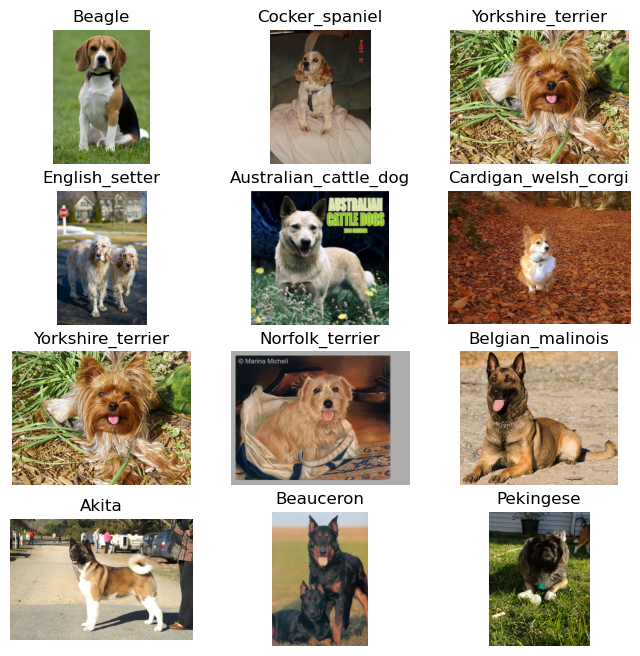

In [5]:
# Plot some of the data
labels_map = pd.read_csv('dogImages/labels.csv')
test_meta = pd.read_csv('dogImages/test/meta.csv')

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 4
for i in range(1, cols * rows + 1):
    sample_idx = random.randint(0, len(test_meta))
    img_path = test_meta.iloc[sample_idx, 1]
    label_id = test_meta.iloc[sample_idx, 0]
    label = labels_map.iloc[int(label_id), 1]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(mpimg.imread(img_path).squeeze(), cmap="gray")
plt.show()
figure.savefig('sample_images.png')

In [6]:
os.environ["DATABASE_PATH"] = "s3://"+ bucket+ "/dogImages/"

In [ ]:
!aws s3 cp dogImages ${DATABASE_PATH} --recursive

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
# Directory path
directory = "model"

# Create 'model' folder if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
    print("Folder 'model' created successfully.")

# Directory path for model_train
directory_train = "model_train"

# Create 'model_train' folder if it doesn't exist
if not os.path.exists(directory_train):
    os.makedirs(directory_train)
    print("Folder 'model_train' created successfully.")

In [8]:
os.environ['MODEL_DIR']="s3://"+ bucket+ "/model/" # where model will be stored
os.environ['TRAIN_MODEL_DIR']="s3://"+ bucket+ "/model_train/" # where model will be stored

In [30]:
# Copy the folder to S3
!aws s3api put-object --bucket sagemaker-us-east-1-026603419603 --key model/

{
    "ETag": "\"d41d8cd98f00b204e9800998ecf8427e\"",
    "ServerSideEncryption": "AES256"
}


In [31]:
!aws s3api put-object --bucket sagemaker-us-east-1-026603419603 --key model_train/

{
    "ETag": "\"d41d8cd98f00b204e9800998ecf8427e\"",
    "ServerSideEncryption": "AES256"
}


In [32]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
}

In [34]:
#! python hpo.py

In [35]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [9]:
# TODO: Fit your HP Tuner
os.environ["SM_CHANNEL_TRAINING"] = "s3://"+ bucket+ "/dogImages/"
os.environ['SM_MODEL_DIR']= "s3://"+ bucket+ "/dogImages/model/" # where model will be stored

In [37]:
tuner.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
.

KeyboardInterrupt: 

In [10]:
BetterTrainingJobName='pytorch-training-230624-2323-001-e81a7cbc'
estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)


2023-06-24 23:36:07 Starting - Preparing the instances for training
2023-06-24 23:36:07 Downloading - Downloading input data
2023-06-24 23:36:07 Training - Training image download completed. Training in progress.
2023-06-24 23:36:07 Uploading - Uploading generated training model
2023-06-24 23:36:07 Completed - Resource released due to keep alive period expiry


In [11]:
best_estimator = estimator

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

{'_tuning_objective_metric': 'Test Loss',
 'batch-size': '"60"',
 'lr': '0.18096406880426816',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-06-24-23-23-10-682"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-026603419603/pytorch-training-2023-06-24-23-23-10-682/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [23]:
# TODO: Set up debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [24]:
# TODO: Create and fit an estimator
hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "lr": 0.0013962824190236237}
print(hyperparameters)

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="debugger-profiler-project3",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=hyperparameters,
    framework_version='1.4.0',
    py_version='py3',
    profiler_config=profiler_config,
    rules=rules,
    debugger_hook_config=hook_config,
)

{'batch-size': 60, 'lr': '0.18096406880426816'}


In [25]:
# TODO: Plot a debugging output.S
os.environ["SM_CHANNEL_TRAINING"] = "s3://"+ bucket+ "/dogImages/"
os.environ['SM_MODEL_DIR']= "s3://"+ bucket+ "/model_train/" 

In [26]:
estimator.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=True)

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: debugger-profiler-project3-2023-08-26-20-56-15-359


2023-08-26 20:56:15 Starting - Starting the training job...
2023-08-26 20:56:46 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-08-26 20:57:46 Downloading - Downloading input data.........
2023-08-26 20:59:17 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-08-26 20:59:21,952 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-08-26 20:59:21,956 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-08-26 20:59:21,968 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-08-26 20:59:21,971 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-08-26 20:59:22,161 sagema

In [27]:
job_name = "debugger-profiler-project3-2023-08-26-20-56-15-359"#estimator.latest_training_job.name
estimator = sagemaker.estimator.Estimator.attach(job_name)
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
debug_artifacts_path = estimator.latest_job_debugger_artifacts_path()
print('Debug Path:', debug_artifacts_path)
print('Job name:', job_name)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole



2023-08-26 21:10:10 Starting - Preparing the instances for training
2023-08-26 21:10:10 Downloading - Downloading input data
2023-08-26 21:10:10 Training - Training image download completed. Training in progress.
2023-08-26 21:10:10 Uploading - Uploading generated training model
2023-08-26 21:10:10 Completed - Training job completed
Debug Path: None
Job name: debugger-profiler-project3-2023-08-26-20-56-15-359


In [32]:
#print("Tensor Names: ",trial.tensor_names())

NameError: name 'trial' is not defined

In [ ]:
from smdebug.core.modes import ModeKeys

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [ ]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

In [34]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [16]:
# bucket_name = "sagemaker-us-east-1-026603419603"
# key = "debugger-profiler-project3-2023-08-25-23-19-11-768/output/model.tar.gz"
# local_path = "model.tar.gz"

# s3 = boto3.client('s3')
# s3.download_file(bucket_name, key, local_path)

In [17]:
# import tarfile

# with tarfile.open(local_path, "r:gz") as tar:
#     tar.extractall()

In [18]:
# os.makedirs("my_model_directory/code", exist_ok=True)
# import shutil

# # Move the model.pth to the new directory
# shutil.move("model.pth", "my_model_directory/code/model.pth")

'my_model_directory/code/model.pth'

In [30]:
# import torch
# import base64
# import io

# state_dict = torch.load('my_model_directory/code/model.pth')

# buffer = io.BytesIO()
# torch.save(state_dict, buffer)
# encoded_weights = base64.b64encode(buffer.getvalue()).decode('utf-8')

In [31]:
# with open('weights_encoded.txt', 'w') as f:
#     f.write(encoded_weights)

In [29]:
# import torch 
# state_dict = torch.load('my_model_directory/code/model.pth')
# print(state_dict)  # This will print the weights for each layer.

OrderedDict([('conv1.weight', tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
           -4.3034e-02, -7.0755e-02],
          [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
           -2.0912e-02, -3.8517e-02],
          [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
            6.2641e-02,  5.1977e-02],
          ...,
          [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
           -7.6604e-02,  7.8453e-03],
          [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
           -3.3662e-02, -1.5709e-02],
          [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
            2.2439e-02,  1.7077e-03]],

         [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
            4.4022e-02, -9.4675e-03],
          [-7.7273e-03,  1.8890e-02,  6.7981e-02,  ...,  1.5956e-01,
            1.4606e-01,  1.1999e-01],
          [-4.6013e-02, -7.6075e-02, -8.9648e-02,  ...,  1.2108e-01,
            1.6705e-01,  1.7

In [60]:
# import torchvision.models as models
# import torch
# model = models.resnet50(pretrained=True)
# torch.save(model.state_dict(), "resnet50-19c8e357.pth")

In [62]:
# !tar -czvf /model_with_pretrained.tar.gz -C /my_model_directory .

tar: /my_model_directory: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
tar (child): /model_with_pretrained.tar.gz: Cannot open: Permission denied
tar (child): Error is not recoverable: exiting now


In [28]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [29]:
model_location=estimator.model_data
print(model_location)
py_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

s3://sagemaker-us-east-1-026603419603/debugger-profiler-project3-2023-08-26-20-56-15-359/output/model.tar.gz


In [30]:
# TODO: Deploy your model to an endpoint
predictor = py_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-026603419603/debugger-profiler-project3-2023-08-26-20-56-15-359/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-026603419603/pytorch-inference-2023-08-26-21-11-16-701/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-08-26-21-11-25-680
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-08-26-21-11-26-429
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-08-26-21-11-26-429


----!

In [31]:
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

In [32]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [33]:
type(response[0][0])


float

In [35]:
response[0]

[-1.7304757833480835,
 0.5353327989578247,
 1.9880677461624146,
 1.518221378326416,
 0.5478665828704834,
 1.470072627067566,
 1.2421423196792603,
 0.09464368224143982,
 2.002763509750366,
 0.511668860912323,
 0.4223860502243042,
 0.5103755593299866,
 1.7211025953292847,
 1.0090866088867188,
 1.908469557762146,
 2.0039432048797607,
 0.3107823431491852,
 0.809339702129364,
 1.3567825555801392,
 1.2282352447509766,
 1.5561633110046387,
 1.233723521232605,
 0.884080171585083,
 1.230689287185669,
 0.9786556959152222,
 1.1526297330856323,
 -0.07719360291957855,
 1.7099965810775757,
 1.1221973896026611,
 0.6895427107810974,
 1.3693771362304688,
 0.9072487354278564,
 1.7587528228759766,
 0.7299090623855591,
 0.9660473465919495,
 -0.13677294552326202,
 1.1700981855392456,
 0.6201133728027344,
 0.5652941465377808,
 1.587783694267273,
 2.103060722351074,
 -0.5771058201789856,
 0.49179694056510925,
 1.089480996131897,
 1.5432744026184082,
 1.5891399383544922,
 1.5521047115325928,
 0.71346992254257

In [36]:
import torch
import numpy as np
np.argmax(response, 1) #array 40 is the correct response. 

array([40])

In [22]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()